In [1]:
# import all libraries we need
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# reading our tables of Premier League matches
matches = pd.read_csv("all_matches.csv")
new_matches = pd.read_csv("all_matches_24_25.csv").drop(columns=['Unnamed: 0'])
matches = pd.concat([matches, new_matches])
matches

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,touches,def pen,def 3rd_y,mid 3rd_y,att 3rd_y,att pen,live,season,team,opp formation
0,0.0,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3.0,0.0,...,835.0,75.0,267.0,412.0,158.0,23.0,835.0,2023-2024,Manchester City,NaN
1,1.0,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1.0,0.0,...,788.0,65.0,212.0,411.0,174.0,21.0,788.0,2023-2024,Manchester City,NaN
2,2.0,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,...,893.0,40.0,153.0,440.0,304.0,53.0,892.0,2023-2024,Manchester City,NaN
3,3.0,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,W,5.0,1.0,...,838.0,64.0,222.0,483.0,138.0,20.0,837.0,2023-2024,Manchester City,NaN
4,4.0,2023-09-16,15:00,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,...,837.0,49.0,148.0,382.0,311.0,49.0,837.0,2023-2024,Manchester City,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,NaN,2025-04-26,15:00,Premier League,Matchweek 34,Sat,Home,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton,NaN
756,NaN,2025-05-03,15:00,Premier League,Matchweek 35,Sat,Away,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton,NaN
757,NaN,2025-05-10,15:00,Premier League,Matchweek 36,Sat,Home,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton,NaN
758,NaN,2025-05-18,15:00,Premier League,Matchweek 37,Sun,Away,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton,NaN


In [3]:
# cleaning our data
matches.drop(columns=['Unnamed: 0', 'comp', 'attendance', 'captain', 'formation', 'referee', 'match report', 'notes', 'dist', 'time'],inplace=True)
matches.drop(columns=['cmp.1', 'cmp.2', 'cmp.3', 'att.1', 'att.2', 'att.3', 'cmp%.1', 'cmp%.2', 'cmp%.3','tkl.1', 'live', 'opp formation'],inplace=True)
matches.rename(columns={'cmp': 'completed passes', 'att': 'passes attempted' , 'cmp%': 'completed passes %'}, inplace=True)
matches.rename(columns={'def 3rd_x': 'takles def 3rd', 'mid 3rd_x': 'takles mid 3rd', 'att 3rd_x': 'takles att 3rd', 'sh_y':'shots blocked', 'pass':'passes blocked'}, inplace=True)
matches.rename(columns={'def pen': 'touches def pen', 'def 3rd_y': 'touches def 3rd', 'mid 3rd_y': 'touches mid 3rd', 'att 3rd_y': 'touches att 3rd', 'att pen': 'touches att pen'}, inplace=True)
matches["date"] = pd.to_datetime(matches['date'])
matches['day'] = matches['date'].dt.dayofweek
matches["round"] = matches["round"].str.replace("Matchweek", "").astype(int)
matches["result"] = matches["result"].astype('category').cat.rename_categories({'W': 3, 'L': 0, 'D': 1})
matches["venue"] = matches["venue"].astype("category").cat.codes
# home - 1
# away - 0
matches

,date,round,day,venue,result,gf,ga,opponent,xg,xga,...,clr,err,touches,touches def pen,touches def 3rd,touches mid 3rd,touches att 3rd,touches att pen,season,team
0,2023-08-11,1,4,0,3,3.0,0.0,Burnley,1.9,0.3,...,7.0,2.0,835.0,75.0,267.0,412.0,158.0,23.0,2023-2024,Manchester City
1,2023-08-19,2,5,1,3,1.0,0.0,Newcastle Utd,1.0,0.3,...,10.0,1.0,788.0,65.0,212.0,411.0,174.0,21.0,2023-2024,Manchester City
2,2023-08-27,3,6,0,3,2.0,1.0,Sheffield Utd,3.5,0.7,...,6.0,0.0,893.0,40.0,153.0,440.0,304.0,53.0,2023-2024,Manchester City
3,2023-09-02,4,5,1,3,5.0,1.0,Fulham,2.2,1.4,...,11.0,0.0,838.0,64.0,222.0,483.0,138.0,20.0,2023-2024,Manchester City
4,2023-09-16,5,5,0,3,3.0,1.0,West Ham,3.6,0.9,...,9.0,0.0,837.0,49.0,148.0,382.0,311.0,49.0,2023-2024,Manchester City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2025-04-26,34,5,1,NaN,NaN,NaN,Fulham,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton
756,2025-05-03,35,5,0,NaN,NaN,NaN,Leicester City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton
757,2025-05-10,36,5,1,NaN,NaN,NaN,Manchester City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton
758,2025-05-18,37,6,0,NaN,NaN,NaN,Everton,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-2025,Southampton


In [4]:
# we do this because the names of footbal clubs doesn't match in the cite from where we will bring team's and opponent's ranks 
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Brighton and Hove Albion": "Brighton",
              "Manchester United": "Manchester Utd",
              "Newcastle United": "Newcastle Utd",
              "Tottenham Hotspur": "Tottenham",
              "West Ham United": "West Ham",
              "Wolverhampton Wanderers": "Wolves",
              "Nottingham Forest": "Nott'ham Forest",
              "Sheffield United": "Sheffield Utd"}
mapping = MissingDict(**map_values)
matches['team'] = matches['team'].map(mapping)

In [5]:
# at first we add in our data last three places because their previous rank couldn't be found

last_three = np.random.choice([18, 19, 20], 1)
# matches['team_rank'] = last_three[0]
# matches['opp. team_rank'] = last_three[0]
matches['prev. team_rank'] = last_three[0]
matches['prev. opp. team_rank'] = last_three[0]

In [6]:
# in this stage we add teams' and opponents' ranks

seasons = ['2024-2025', '2023-2024', '2022-2023', '2021-2022']
for i in range(4):
    season_matches = matches[matches['season'] == seasons[i]]
    standings_url = f'https://fbref.com/en/comps/9/{seasons[i]}/{seasons[i]}-Premier-League-Stats'
    
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    data = requests.get(standings_url)
    
    rank_table = pd.read_html(data.text)[0]
    rank_table = rank_table[['Rk', 'Squad']]
    rank_dict = rank_table.set_index('Squad').to_dict()['Rk']
    season_matches['team'] = season_matches['team'].map(mapping)

    for team in season_matches['team'].unique():
        matches.loc[(matches['season'] == seasons[i]) & (matches['team'] == team), 'team_rank'] = rank_dict[team]
        matches.loc[(matches['season'] == seasons[i]) & (matches['opponent'] == team), 'opp. team_rank'] = rank_dict[team]

C:\Users\HP\AppData\Local\Temp\ipykernel_5460\3274746286.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rank_table = pd.read_html(data.text)[0]
C:\Users\HP\AppData\Local\Temp\ipykernel_5460\3274746286.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_matches['team'] = season_matches['team'].map(mapping)
C:\Users\HP\AppData\Local\Temp\ipykernel_5460\3274746286.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rank_table = pd.read_html(data.text)[0]
C:\Users\HP\AppData\Local\Temp\ipyk

In [9]:
# in this stage we add teams' and opponents' ranks for their previous season

seasons = ['2023-2024', '2022-2023', '2021-2022', '2020-2021']
for i in range(3):
    season_matches = matches[matches['season'] == seasons[i+1]]
    standings_url = f'https://fbref.com/en/comps/9/{seasons[i+1]}/{seasons[i+1]}-Premier-League-Stats'
    
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    data = requests.get(standings_url)
    
    rank_table = pd.read_html(data.text)[0]
    rank_table = rank_table[['Rk', 'Squad']]
    rank_dict = rank_table.set_index('Squad').to_dict()['Rk']
    season_matches['team'] = season_matches['team'].map(mapping)

    for team in season_matches['team'].unique():
        matches.loc[(matches['season'] == seasons[i]) & (matches['team'] == team), 'prev. team_rank'] = rank_dict[team]
        matches.loc[(matches['season'] == seasons[i]) & (matches['opponent'] == team), 'prev. opp. team_rank'] = rank_dict[team]

C:\Users\HP\AppData\Local\Temp\ipykernel_5460\2099833598.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rank_table = pd.read_html(data.text)[0]
C:\Users\HP\AppData\Local\Temp\ipykernel_5460\2099833598.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_matches['team'] = season_matches['team'].map(mapping)
C:\Users\HP\AppData\Local\Temp\ipykernel_5460\2099833598.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  rank_table = pd.read_html(data.text)[0]
C:\Users\HP\AppData\Local\Temp\ipyk

In [10]:
matches

,date,round,day,venue,result,gf,ga,opponent,xg,xga,...,touches def 3rd,touches mid 3rd,touches att 3rd,touches att pen,season,team,prev. team_rank,prev. opp. team_rank,team_rank,opp. team_rank
0,2023-08-11,1,4,0,3,3.0,0.0,Burnley,1.9,0.3,...,267.0,412.0,158.0,23.0,2023-2024,Manchester City,1,18,1.0,19.0
1,2023-08-19,2,5,1,3,1.0,0.0,Newcastle Utd,1.0,0.3,...,212.0,411.0,174.0,21.0,2023-2024,Manchester City,1,4,1.0,7.0
2,2023-08-27,3,6,0,3,2.0,1.0,Sheffield Utd,3.5,0.7,...,153.0,440.0,304.0,53.0,2023-2024,Manchester City,1,18,1.0,20.0
3,2023-09-02,4,5,1,3,5.0,1.0,Fulham,2.2,1.4,...,222.0,483.0,138.0,20.0,2023-2024,Manchester City,1,10,1.0,13.0
4,2023-09-16,5,5,0,3,3.0,1.0,West Ham,3.6,0.9,...,148.0,382.0,311.0,49.0,2023-2024,Manchester City,1,14,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2025-04-26,34,5,1,NaN,NaN,NaN,Fulham,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,7.0
756,2025-05-03,35,5,0,NaN,NaN,NaN,Leicester City,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,15.0
757,2025-05-10,36,5,1,NaN,NaN,NaN,Manchester City,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,2.0
758,2025-05-18,37,6,0,NaN,NaN,NaN,Everton,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,16.0


In [21]:
# in this stage we will fit our ml model

pred_matches = matches[matches['result'].isna()]
cmp_matches = matches[~matches['result'].isna()].fillna(0)

rf = RandomForestClassifier(n_estimators=120, min_samples_split=10, random_state=42)
predictors = ['round', 'xg', 'sot%', 'xa', 'npxg', 'npxg/sh', 'xag', 'kp',
         'touches', 'team_rank', 'opp. team_rank', 'prev. team_rank', 'prev. opp. team_rank','touches att pen', 'touches def pen', 'totdist', 'prgdist',
       'passes attempted', 'completed passes %', 'tkl', 'tklw', 'takles def 3rd','int', 'venue',
       'tkl+int', 'day', 'poss']
X, y = cmp_matches[predictors], cmp_matches['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.729518855656697
[[143  59  25]
 [ 25 272  20]
 [ 28  51 146]]


In [12]:
# at this point we duplicate our data where the result is draw, because our model can't predict draws properly
# and we will train our model again
draws = matches[matches['result'] == 1]
matches = pd.concat([draws, matches], ignore_index=True)
matches

,date,round,day,venue,result,gf,ga,opponent,xg,xga,...,touches def 3rd,touches mid 3rd,touches att 3rd,touches att pen,season,team,prev. team_rank,prev. opp. team_rank,team_rank,opp. team_rank
0,2023-11-12,12,6,0,1,4.0,4.0,Chelsea,2.9,2.9,...,202.0,289.0,212.0,42.0,2023-2024,Manchester City,1,12,1.0,6.0
1,2023-11-25,13,5,1,1,1.0,1.0,Liverpool,1.3,0.6,...,247.0,304.0,214.0,36.0,2023-2024,Manchester City,1,5,1.0,3.0
2,2023-12-03,14,6,1,1,3.0,3.0,Tottenham,2.6,0.5,...,188.0,273.0,267.0,47.0,2023-2024,Manchester City,1,8,1.0,5.0
3,2023-12-16,17,5,1,1,2.0,2.0,Crystal Palace,1.6,1.8,...,113.0,453.0,390.0,31.0,2023-2024,Manchester City,1,11,1.0,10.0
4,2024-02-17,25,5,1,1,1.0,1.0,Chelsea,2.6,1.4,...,150.0,366.0,395.0,75.0,2023-2024,Manchester City,1,12,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,2025-04-26,34,5,1,NaN,NaN,NaN,Fulham,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,7.0
3610,2025-05-03,35,5,0,NaN,NaN,NaN,Leicester City,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,15.0
3611,2025-05-10,36,5,1,NaN,NaN,NaN,Manchester City,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,2.0
3612,2025-05-18,37,6,0,NaN,NaN,NaN,Everton,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-2025,Southampton,18,18,20.0,16.0


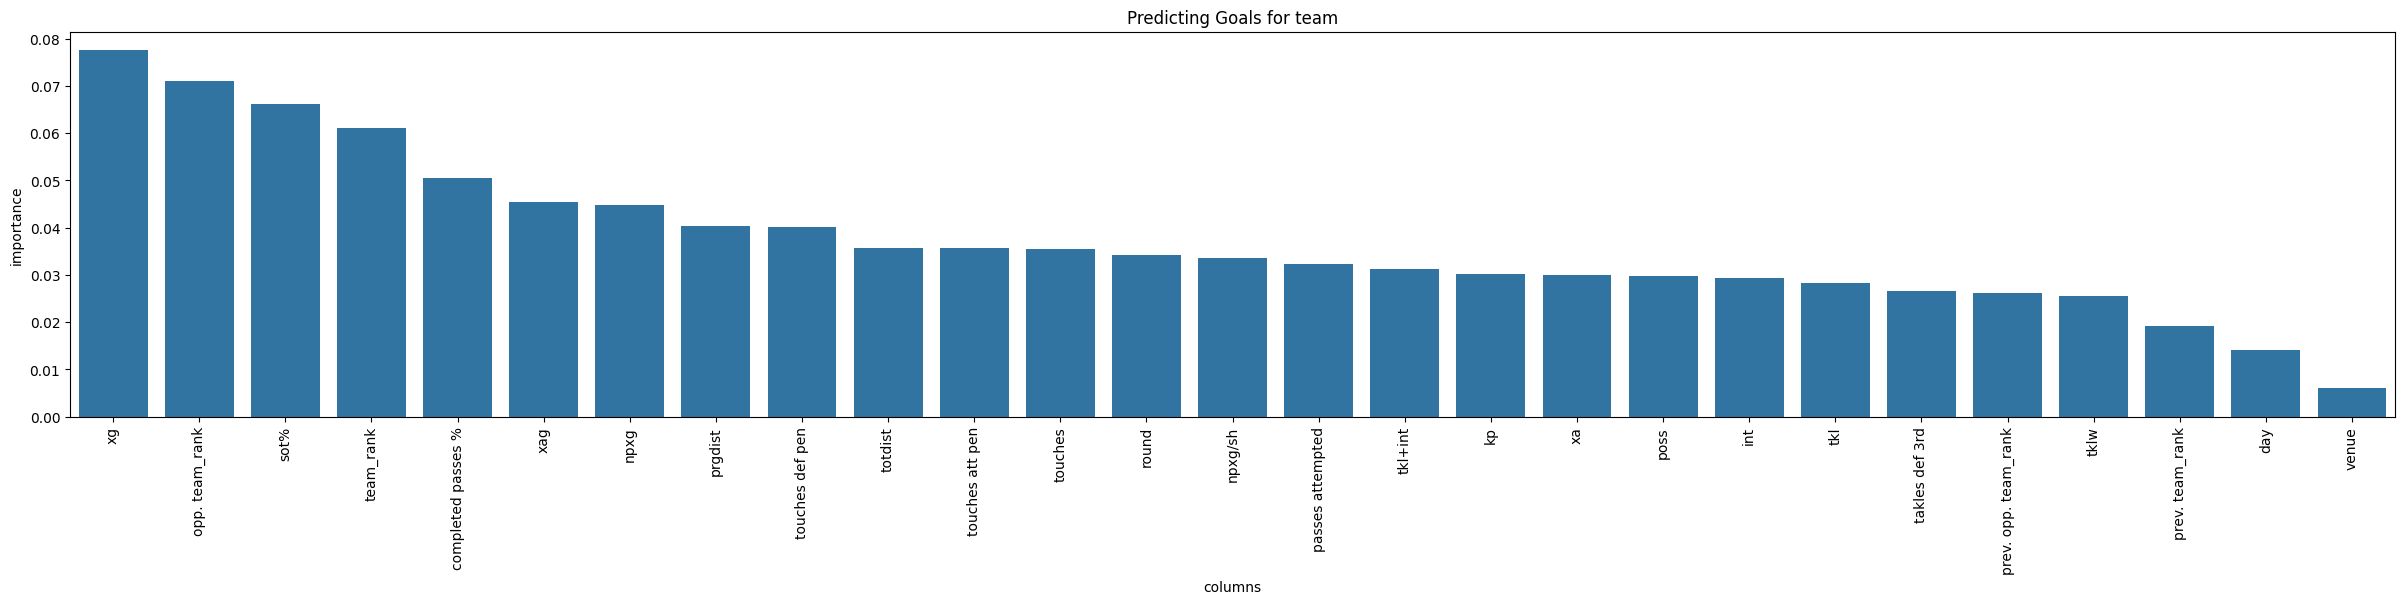

In [14]:
# this graphic shows us the imporance of each column 
plt.figure(figsize=(30,5))
imp = pd.DataFrame({'columns': predictors, 'importance': rf.feature_importances_})
imp.sort_values('importance', ascending=False,inplace=True)
sns.barplot(x=imp['columns'], y=imp['importance'])
plt.title("Predicting Goals for team")
plt.xticks(rotation=90)
plt.show()

In [15]:
# and we choose columns depending on the previous graph

cols = ['xg', 'xa','sot%', 'npxg', 'npxg/sh', 'xag', 'kp',
        'touches','touches att pen', 'touches def pen', 'totdist', 'prgdist',
       'passes attempted', 'completed passes %', 'tkl', 'tklw', 'takles def 3rd','int',
       'tkl+int', 'poss']

In [16]:
# using this code we will try to predict the future performances of each club

def predicting_features(group, col):
    group.reset_index(drop=True, inplace=True)
    team = group.team.unique()[0]
    if team == 'Ipswich Town':
        cmp_team = cmp_matches[cmp_matches['team_rank'] == last_three[0]]
    else:       
        cmp_team = cmp_matches[cmp_matches['team'] == team]
    pred_team = pred_matches[pred_matches['team'] == team]
    train, test = cmp_team[cmp_team['season'] != '2024-2025'], cmp_team[cmp_team['season'] == '2024-2025'] 
    
    for col in cols:
        try: 
            x_train, y_train = train[['opp. team_rank']], train[[col]]
            x_test, y_test = test[['opp. team_rank']], test[[col]]
            reg = KNeighborsRegressor(n_neighbors = 8)
            reg.fit(x_train, y_train)  
    
            x_pred = pred_team[['opp. team_rank']]
            y = reg.predict(x_pred)
            pred_team.loc[:, col] = y.round(1)
        except ValueError:
            print(team)
            continue
    
        
    return pred_team
      
all_pred_matches = pred_matches.groupby(by='team').apply(lambda x:  predicting_features(x, cols))
all_pred_matches

C:\Users\HP\AppData\Local\Temp\ipykernel_5460\3875308165.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_pred_matches = pred_matches.groupby(by='team').apply(lambda x:  predicting_features(x, cols))


date  round  day  venue result  gf  ga         opponent  \
team                                                                         
Arsenal 2979 2024-11-23     12    5      1    NaN NaN NaN  Nott'ham Forest   
        2980 2024-11-30     13    5      0    NaN NaN NaN         West Ham   
        2981 2024-12-04     14    2      1    NaN NaN NaN   Manchester Utd   
        2982 2024-12-08     15    6      0    NaN NaN NaN           Fulham   
        2983 2024-12-14     16    5      1    NaN NaN NaN          Everton   
...                 ...    ...  ...    ...    ...  ..  ..              ...   
Wolves  3571 2025-04-26     34    5      1    NaN NaN NaN   Leicester City   
        3572 2025-05-03     35    5      0    NaN NaN NaN  Manchester City   
        3573 2025-05-10     36    5      1    NaN NaN NaN         Brighton   
        3574 2025-05-18     37    6      0    NaN NaN NaN   Crystal Palace   
        3575 2025-05-25     38    6      1    NaN NaN NaN        Brentford   

               xg  xga  ...  touches def 3rd  touches mid 3rd  \
team                    ...                                     
Arsenal 2979  1.6  NaN  ...              NaN              NaN   
        2980  2.2  NaN  ...              NaN              NaN   
        2981  2.4  NaN  ...              NaN              NaN   
        2982  2.1  NaN  ...              NaN              NaN   
        2983  1.8  NaN  ...              NaN              NaN   
...           ...  ...  ...              ...              ...   
Wolves  3571  1.4  NaN  ...              NaN              NaN   
        3572  0.6  NaN  ...              NaN              NaN   
        3573  1.2  NaN  ...              NaN              NaN   
        3574  0.9  NaN  ...              NaN              NaN   
        3575  1.3  NaN  ...              NaN              NaN   

              touches att 3rd  touches att pen     season     team  \
team                                                                 
Arsenal 2979              NaN             29.5  2024-2025  Arsenal   
        2980              NaN             32.9  2024-2025  Arsenal   
        2981              NaN             39.0  2024-2025  Arsenal   
        2982              NaN             33.5  2024-2025  Arsenal   
        2983              NaN             35.6  2024-2025  Arsenal   
...                       ...              ...        ...      ...   
Wolves  3571              NaN             24.5  2024-2025   Wolves   
        3572              NaN             11.1  2024-2025   Wolves   
        3573              NaN             17.6  2024-2025   Wolves   
        3574              NaN             21.0  2024-2025   Wolves   
        3575              NaN             18.2  2024-2025   Wolves   

              prev. team_rank  prev. opp. team_rank  team_rank  opp. team_rank  
team                                                                            
Arsenal 2979               18                    18        4.0             5.0  
        2980               18                    18        4.0            14.0  
        2981               18                    18        4.0            13.0  
        2982               18                    18        4.0             7.0  
        2983               18                    18        4.0            16.0  
...                       ...                   ...        ...             ...  
Wolves  3571               18                    18       19.0            15.0  
        3572               18                    18       19.0             2.0  
        3573               18                    18       19.0             6.0  
        3574               18                    18       19.0            18.0  
        3575               18                    18       19.0            11.0  

[540 rows x 53 columns]

In [107]:
# this is the example of how it works with one team


# cmp_ipswich = cmp_matches[cmp_matches['team_rank'] == 20]
# pred_ipswich = pred_matches[pred_matches['team'] == 'Ipswich Town']
# train, test = cmp_ipswich[cmp_ipswich['season'] != '2024-2025'], cmp_ipswich[cmp_ipswich['season'] == '2024-2025'] 
    
# for col in cols:
#     x_train, y_train = train[['opp. team_rank']], train[[col]]
#     x_test, y_test = test[['opp. team_rank']], test[[col]]
    
#     reg = KNeighborsRegressor(n_neighbors = 7)
#     reg.fit(x_train, y_train)  
#     y_pred = reg.predict(x_test)
#     mse = mean_squared_error(y_test, y_pred)
#     x_pred = pred_ipswich[['opp. team_rank']]
#     y = reg.predict(x_pred)
#     pred_ipswich.loc[:, col] = y.round(1)
#     print(f'{col}: {mse}')
# pred_ipswich


In [17]:
# with this code we convert our data to the way it was
all_pred_matches = all_pred_matches.droplevel('team')
matches = matches.fillna(all_pred_matches)

In [18]:
# and finaly we predict the result of matches in the season 2024-2025

matches24_25 = matches[matches['season'] == '2024-2025'] 
pred_matches24_25 = matches24_25[matches24_25['result'].isna()]
pred_matches24_25['result'] = rf.predict(pred_matches24_25[predictors])
matches24_25.result = matches24_25.result.fillna(pred_matches24_25['result']).astype('int')

C:\Users\HP\AppData\Local\Temp\ipykernel_5460\3268856206.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_matches24_25['result'] = rf.predict(pred_matches24_25[predictors])
C:\Users\HP\AppData\Local\Temp\ipykernel_5460\3268856206.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches24_25.result = matches24_25.result.fillna(pred_matches24_25['result']).astype('int')


In [19]:
matches24_25['result']

514     1
515     1
516     1
517     1
518     1
       ..
3609    0
3610    0
3611    0
3612    1
3613    0
Name: result, Length: 820, dtype: int32

In [20]:
matches24_25.groupby(by='team').agg({'result': 'sum'}).sort_values(by=['result'], ascending=False)
# as we see in our prediction Liverpool will become champion this year

,result
team,
Liverpool,102
Manchester City,98
Arsenal,95
Chelsea,94
Brighton,88
Newcastle Utd,75
Fulham,70
Tottenham,68
Aston Villa,68
